In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [11]:
dataset_path = "/Tomato"

In [13]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [19]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [21]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 2 2 0 2 1 2 2 2 2 1 1 2 1 1 1 0 1 1 0 0 1 0 1 1 2 0 1 1 1]


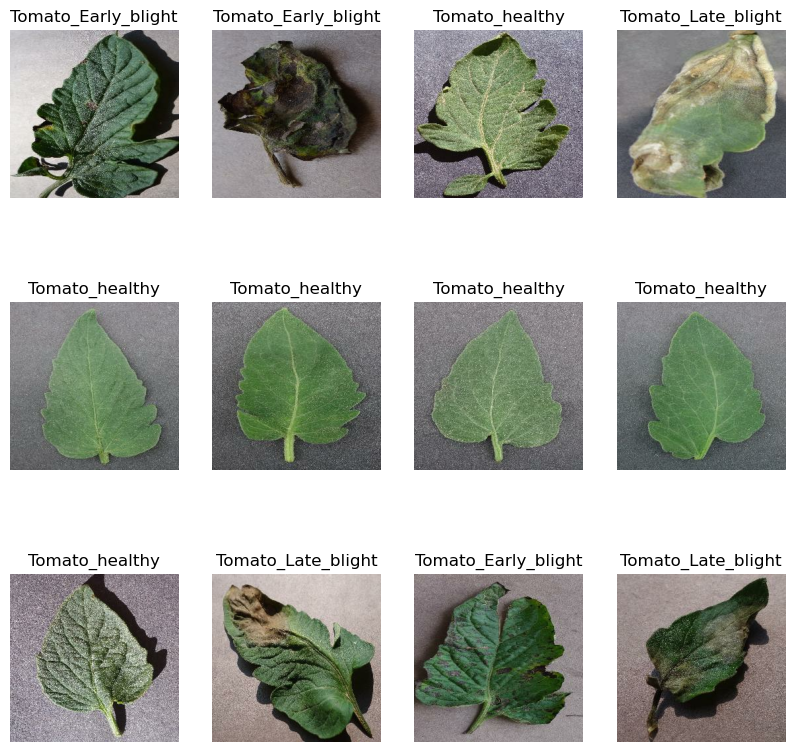

In [23]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [25]:
len(dataset)

141

In [27]:
train_size = 0.8
len(dataset)*train_size

112.80000000000001

In [29]:
train_ds = dataset.take(112)
len(train_ds)

112

In [31]:
test_ds = dataset.skip(112)
len(test_ds)

29

In [33]:
val_size=0.1
len(dataset)*val_size

14.100000000000001

In [35]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [37]:
test_ds = test_ds.skip(14)
len(test_ds)

15

In [39]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [43]:
len(train_ds)

112

In [45]:
len(val_ds)

14

In [47]:
len(test_ds)

15

In [49]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [53]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [55]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [57]:
# Define input shape
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Remove BATCH_SIZE
n_classes = 3

# Build model
model = models.Sequential([
    layers.Input(shape=input_shape),  # ✅ Define input shape at the start
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Check model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [61]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 70s 524ms/step - accuracy: 0.4364 - loss: 1.0491 - val_accuracy: 0.7522 - val_loss: 0.6599
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 60s 530ms/step - accuracy: 0.7224 - loss: 0.6440 - val_accuracy: 0.7589 - val_loss: 0.5490
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 58s 517ms/step - accuracy: 0.8031 - loss: 0.4698 - val_accuracy: 0.8415 - val_loss: 0.3755
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - accuracy: 0.8402 - loss: 0.3654 - val_accuracy: 0.8616 - val_loss: 0.3618
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 62s 547ms/step - accuracy: 0.8663 - loss: 0.3265 - val_accuracy: 0.8103 - val_loss: 0.4209
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 62s 552ms/step - accuracy: 0.8825 - loss: 0.2788 - val_accuracy: 0.9018 - val_loss: 0.2854
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 60s 534ms/step - accuracy: 0.9089 - loss: 0.2455 - val_accuracy: 0.8884 - val_loss: 0.2897
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 61s 537ms/step - accuracy: 0.8708 - loss: 0

In [63]:
scores = model.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.9773 - loss: 0.0681


In [65]:
scores

[0.0801335871219635, 0.96875]

In [67]:
history

In [69]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 112}

In [71]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [73]:
type(history.history['loss'])

list

In [75]:
len(history.history['loss'])

50

In [77]:
history.history['loss'][:5]

[0.9777662754058838,
 0.5998878479003906,
 0.46734628081321716,
 0.321851521730423,
 0.32161945104599]

In [79]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

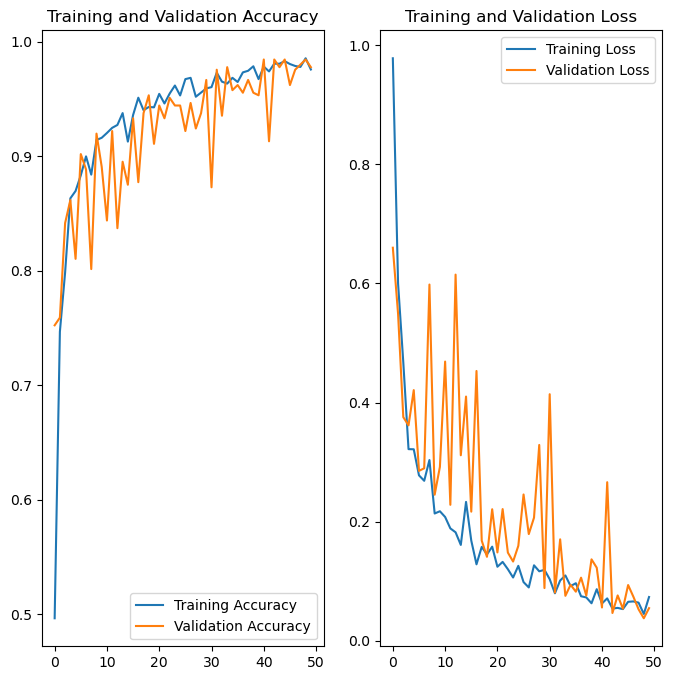

In [81]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
predicted label: Tomato_Late_blight


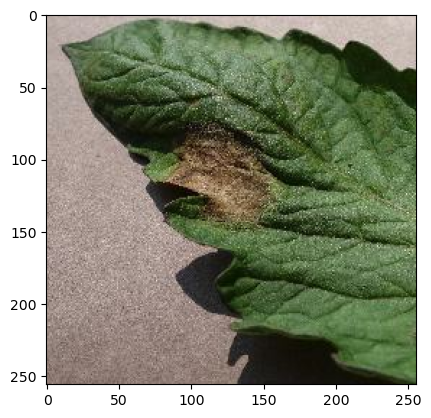

In [83]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [85]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


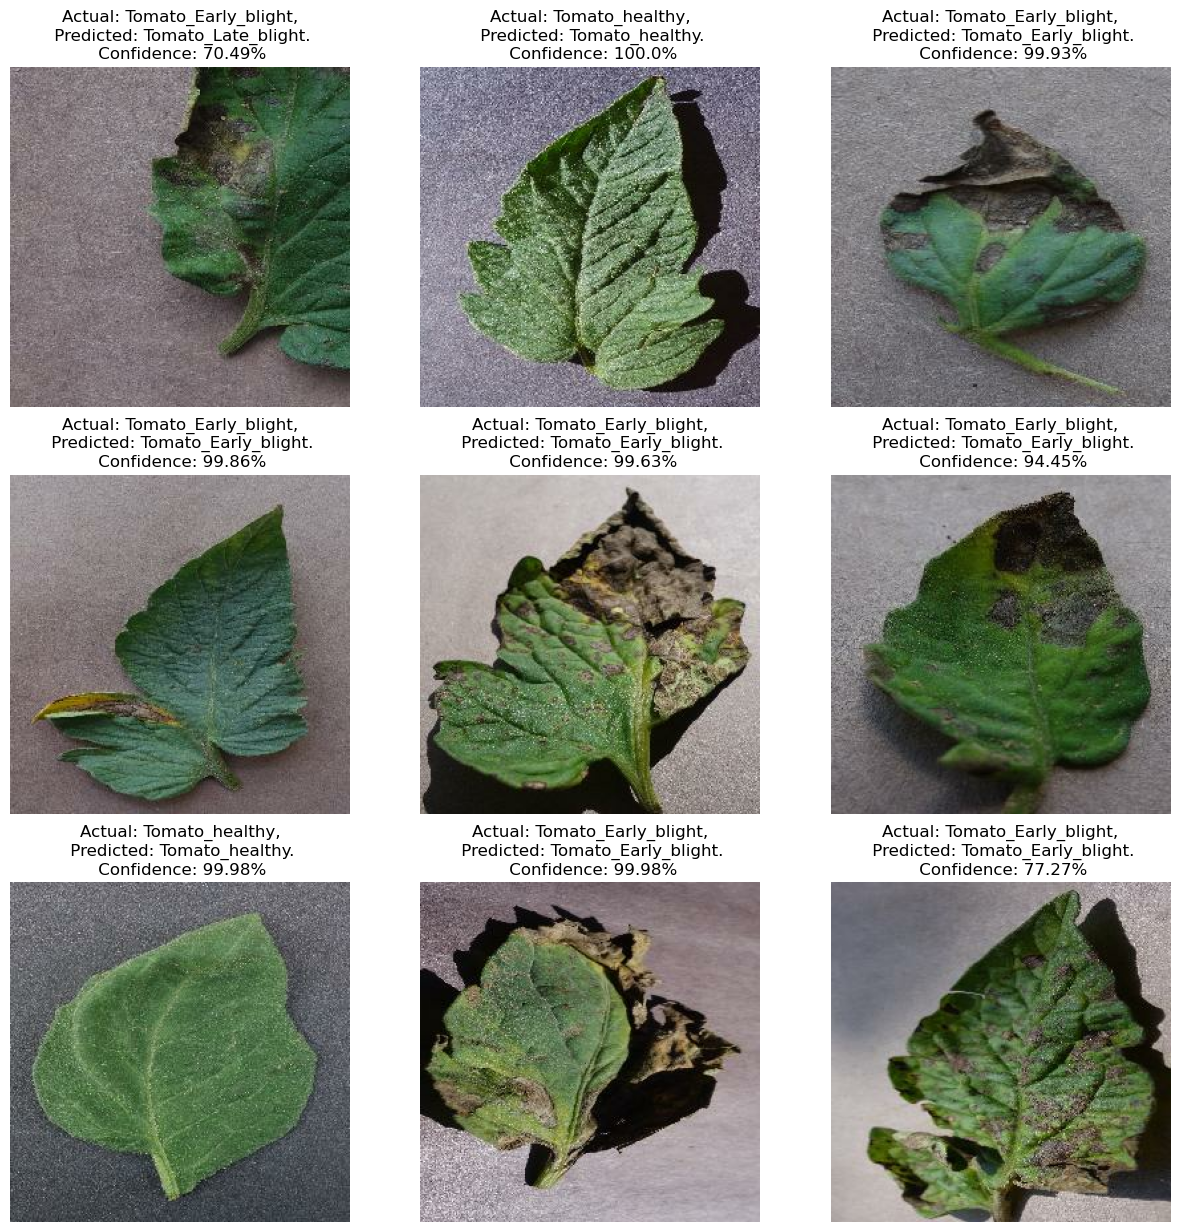

In [117]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [109]:
import os

# Ensure the models directory exists
models_dir = "../models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Directory '{models_dir}' created.")

# Get the latest model version
try:
    model_version = max([int(i.split(".")[0]) for i in os.listdir(models_dir) if i.endswith((".keras", ".h5"))] + [0]) + 1
except FileNotFoundError:
    print(f"Error: Directory '{models_dir}' not found.")
    model_version = 1  # Default to version 1 if the directory is missing

# Save the model with a valid extension
model_filepath = f"{models_dir}/{model_version}.keras"  # or use .h5
model.save(model_filepath)
print(f"Model saved to '{model_filepath}'.")

Model saved to '../models/2.keras'.


In [111]:
model.save("my_model.keras")
print("Model saved as 'my_model.keras'.")

Model saved as 'my_model.keras'.


In [113]:
loaded_model = tf.keras.models.load_model("my_model.keras")  # or "my_model.h5"
print("Model loaded successfully.")

Model loaded successfully.


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 18 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
